Biwei's Transformation Code + Headers

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import scipy.ndimage as ndimage
import scipy.stats as stats

def Percentile(input, percentiles):
    """
    Find the percentiles of a tensor along the last dimension.
    Adapted from https://github.com/aliutkus/torchpercentile/blob/master/torchpercentile/percentile.py
    """
    percentiles = percentiles.double()
    in_sorted, in_argsort = torch.sort(input, dim=-1)
    positions = percentiles * (input.shape[-1]-1) / 100
    floored = torch.floor(positions)
    ceiled = floored + 1
    ceiled[ceiled > input.shape[-1] - 1] = input.shape[-1] - 1
    weight_ceiled = positions-floored
    weight_floored = 1.0 - weight_ceiled
    d0 = in_sorted[..., floored.long()] * weight_floored
    d1 = in_sorted[..., ceiled.long()] * weight_ceiled
    result = d0+d1
    return result

class kde(object):
    """
    Adapted from Scipy's KDE estimator:
    https://github.com/scipy/scipy/blob/master/scipy/stats/kde.py
    """

    def __init__(self, dataset, bw_factor=None, weights=None, batchsize=None):
        if dataset.ndim == 1:
            self.dataset = dataset[:, None]
        elif dataset.ndim == 2:
            self.dataset = dataset
        else:
            raise ValueError("`dataset` should be a 1-d or 2-d array.")

        self.n, self.d = self.dataset.shape
        self.weights = weights

        if weights is not None:
            self.weights /= torch.sum(self.weights)
            if self.weights.ndim != 1:
                raise ValueError("`weights` input should be one-dimensional.")
            if len(self.weights) != self.n:
                raise ValueError("`weights` input should be of length n")
            self.neff = 1 / torch.sum(self.weights**2)
            self.weights = self.weights.view(-1,1)
        else:
            self.neff = self.n
        
        self.bw_factor = bw_factor if bw_factor is not None else 1
        self.factor = self.neff ** (-1. / (self.d + 4)) * self.bw_factor
        
        if weights is None:
            data = self.dataset - torch.mean(self.dataset, dim=0)
            self._data_covariance = data.T @ data / (self.n - 1)
        else:
            data = self.dataset - torch.sum(self.dataset*self.weights, dim=0)
            self._data_covariance = (self.weights * data).T @ data / (1 - torch.sum(self.weights**2))
        
        self._data_inv_cov = torch.pinverse(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = torch.sqrt(torch.det(2 * math.pi * self.covariance))
        self.batchsize = batchsize


    def _diff(self, x, dataset):
        """Utility for evaluating pdf and cdf_1d."""
        points = x[:, None] if x.ndim == 1 else x

        m, d = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = points.view(1, self.d)
                d = self.d
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        return points[None, :, :] - dataset[:, None, :]
        # (# of data, # of points, # of dim)

    def pdf(self, x):
        """Evaluate the estimated pdf on a set of points.
        
        Parameters
        ----------
        x : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.
        
        Returns
        -------
        values : (# of points,)-array
            The values at each point.
        
        Raises
        ------
        ValueError
            If the dimensionality of the input points is different than
            the dimensionality of the KDE.
        
        """
        if self.batchsize is not None:
            result = torch.zeros_like(x)
            i = 0
            while i * self.batchsize < self.n:

                diff = self._diff(x, self.dataset[i*self.batchsize: (i+1)*self.batchsize])
                energy = torch.einsum("lmi,ij,lmj->lm", diff, self.inv_cov / 2, diff)
                if self.weights is None:
                    result += torch.sum(torch.exp(-energy), dim=0) / self._norm_factor / self.n
                else:
                    result += torch.sum(self.weights * torch.exp(-energy), dim=0) / self._norm_factor

                i += 1
        else:
            diff = self._diff(x, self.dataset)
            energy = torch.einsum("lmi,ij,lmj->lm", diff, self.inv_cov / 2, diff)
            if self.weights is None:
                result = torch.sum(torch.exp(-energy), dim=0) / self._norm_factor / self.n
            else:
                result = torch.sum(self.weights * torch.exp(-energy), dim=0) / self._norm_factor

        return result

    __call__ = pdf


    def cdf(self, x):
        """Evaluate the estimated cdf on a set of 1-d points.
        
        Parameters
        ----------
        x : (# of points)-array
            Alternatively, a scalar can be passed in and
            treated as a single point.
        
        Returns
        -------
        values : (# of points,)-array
            The values at each point.
        
        Raises
        ------
        NotImplementedError
            If KDE is not 1-d.
        ValueError
            If the dimensionality of the input points is different than
            the dimensionality of the KDE.
        
        """
        if self.d != 1:
            msg = "currently only supports cdf for 1-d kde"
            raise NotImplementedError(msg)
        
        if self.batchsize is not None:
            i = 0
            result = torch.zeros_like(x)

            while i * self.batchsize < self.n:

                diff = self._diff(x, self.dataset[i*self.batchsize: (i+1)*self.batchsize])[:, :, 0]
                diff_scaled = diff / self.covariance**0.5
                if self.weights is None:
                    result += torch.sum(0.5 * (1 + torch.erf(diff_scaled / 2**0.5)), dim=0) / self.n
                else:
                    result += torch.sum(self.weights * 0.5 * (1 + torch.erf(diff_scaled / 2**0.5)), dim=0)
                
                i += 1
        else:
            diff = self._diff(x, self.dataset)[:, :, 0]
            diff_scaled = diff / self.covariance**0.5
            if self.weights is None:
                result = torch.sum(0.5 * (1 + torch.erf(diff_scaled / 2**0.5)), dim=0) / self.n
            else:
                result = torch.sum(self.weights * 0.5 * (1 + torch.erf(diff_scaled / 2**0.5)), dim=0)

        return result


def SearchSorted(a, v, side='left'):
    assert side in ['left', 'right']
    if side == 'left':
        return torch.sum(v[..., None] > a, dim=-1)
    else:
        return torch.sum(v[..., None] >= a, dim=-1)


class RQspline(nn.Module):
    '''
    Ratianal quadratic spline.
    See appendix A.1 of https://arxiv.org/pdf/1906.04032.pdf
    The main advantage compared to cubic spline is that the
    inverse is analytical and does not require binary search

    x: (ndim, nknot) 2d array, each row should be monotonic increasing
    y: (ndim, nknot) 2d array, each row should be monotonic increasing
    deriv: (ndim, nknot) 2d array, should be positive
    '''

    def __init__(self, ndim, nknot):

        super().__init__()
        self.ndim = ndim
        self.nknot = nknot

        x0 = torch.rand(ndim, 1)-4.5
        logdx = torch.log(torch.abs(-2*x0 / (nknot-1)))

        #use log as parameters to make sure monotonicity
        self.x0 = nn.Parameter(x0)
        self.y0 = nn.Parameter(x0.clone())
        self.logdx = nn.Parameter(torch.ones(ndim, nknot-1)*logdx)
        self.logdy = nn.Parameter(torch.ones(ndim, nknot-1)*logdx)
        self.logderiv = nn.Parameter(torch.zeros(ndim, nknot))


    def set_param(self, x, y, deriv):

        dx = x[:,1:] - x[:,:-1]
        dy = y[:,1:] - y[:,:-1]
        assert (dx > 0).all()
        assert (dy > 0).all()
        assert (deriv > 0).all()

        self.x0[:] = x[:, 0].view(-1,1)
        self.y0[:] = y[:, 0].view(-1,1)
        self.logdx[:] = torch.log(dx)
        self.logdy[:] = torch.log(dy)
        self.logderiv[:] = torch.log(deriv)


    def _prepare(self):
        #return knot points and derivatives
        xx = torch.cumsum(torch.exp(self.logdx), dim=1)
        xx += self.x0
        xx = torch.cat((self.x0, xx), dim=1)
        yy = torch.cumsum(torch.exp(self.logdy), dim=1)
        yy += self.y0
        yy = torch.cat((self.y0, yy), dim=1)
        delta = torch.exp(self.logderiv)
        return xx, yy, delta

    def forward(self, x):
        # x: (ndata, ndim) 2d array
        xx, yy, delta = self._prepare() #(ndim, nknot)

        index = SearchSorted(xx, x)
        y = torch.zeros_like(x)
        logderiv = torch.zeros_like(x)

        #linear extrapolation
        select0 = index == 0
        dim = torch.repeat_interleave(torch.arange(self.ndim).view(1,-1), len(x), dim=0)[select0]
        y[select0] = yy[dim, 0] + (x[select0]-xx[dim, 0]) * delta[dim, 0]
        logderiv[select0] = self.logderiv[dim, 0]
        selectn = index == self.nknot
        dim = torch.repeat_interleave(torch.arange(self.ndim).view(1,-1), len(x), dim=0)[selectn]
        y[selectn] = yy[dim, -1] + (x[selectn]-xx[dim, -1]) * delta[dim, -1]
        logderiv[selectn] = self.logderiv[dim, -1]

        #rational quadratic spline
        select = ~(select0 | selectn)
        index = index[select]
        dim = torch.repeat_interleave(torch.arange(self.ndim).view(1,-1), len(x), dim=0)[select]
        xi = (x[select] - xx[dim, index-1]) / (xx[dim, index] - xx[dim, index-1])
        s = (yy[dim, index]-yy[dim, index-1]) / (xx[dim, index]-xx[dim, index-1])
        xi1_xi = xi*(1-xi)
        denominator = s + (delta[dim, index]+delta[dim, index-1]-2*s)*xi1_xi
        xi2 = xi**2

        y[select] = yy[dim, index-1] + ((yy[dim, index]-yy[dim, index-1]) * (s*xi2+delta[dim, index-1]*xi1_xi)) / denominator
        logderiv[select] = 2*torch.log(s) + torch.log(delta[dim, index]*xi2 + 2*s*xi1_xi + delta[dim, index-1]*(1-xi)**2) - 2 * torch.log(denominator)

        return y, logderiv

    def inverse(self, y):
        xx, yy, delta = self._prepare()

        index = SearchSorted(yy, y)
        x = torch.zeros_like(y)
        logderiv = torch.zeros_like(y)

        #linear extrapolation
        select0 = index == 0
        dim = torch.repeat_interleave(torch.arange(self.ndim).view(1,-1), len(x), dim=0)[select0]
        x[select0] = xx[dim, 0] + (y[select0]-yy[dim, 0]) / delta[dim, 0]
        logderiv[select0] = self.logderiv[dim, 0]
        selectn = index == self.nknot
        dim = torch.repeat_interleave(torch.arange(self.ndim).view(1,-1), len(x), dim=0)[selectn]
        x[selectn] = xx[dim, -1] + (y[selectn]-yy[dim, -1]) / delta[dim, -1]
        logderiv[selectn] = self.logderiv[dim, -1]

        #rational quadratic spline
        select = ~(select0 | selectn)
        index = index[select]
        dim = torch.repeat_interleave(torch.arange(self.ndim).view(1,-1), len(x), dim=0)[select]
        deltayy = yy[dim, index]-yy[dim, index-1]
        s = deltayy / (xx[dim, index]-xx[dim, index-1])
        delta_2s = delta[dim, index]+delta[dim, index-1]-2*s
        deltay_delta_2s = (y[select]-yy[dim, index-1]) * delta_2s

        a = deltayy * (s-delta[dim, index-1]) + deltay_delta_2s
        b = deltayy * delta[dim, index-1] - deltay_delta_2s
        c = - s * (y[select]-yy[dim, index-1])
        discriminant = b.pow(2) - 4 * a * c
        assert (discriminant >= 0).all()
        xi = - 2*c / (b + torch.sqrt(discriminant))
        xi1_xi = xi * (1-xi)

        x[select] = xi * (xx[dim, index] - xx[dim, index-1]) + xx[dim, index-1]
        logderiv[select] = 2*torch.log(s) + torch.log(delta[dim, index]*xi**2 + 2*s*xi1_xi + delta[dim, index-1]*(1-xi)**2) - 2 * torch.log(s + delta_2s*xi1_xi)

        return x, logderiv


class SlicedTransport_pointwise(nn.Module):

    def __init__(self, interp_nbin=100):

        super().__init__()
        self.interp_nbin = interp_nbin

        self.transform = RQspline(1, interp_nbin)


    def fit(self, data, bw_factor=1, extrapolate='regression', edge_bins=2, alpha=0, derivclip=None, batchsize=None):

        #forward method

        assert extrapolate in ['endpoint', 'regression']
        assert self.interp_nbin > 2 * edge_bins

        with torch.no_grad():
            data = torch.flatten(data)

            #build rational quadratic spline transform using kde
            start = 100 / (self.interp_nbin-2*edge_bins+1)
            end = 100-start
            q1 = torch.linspace(start, end, self.interp_nbin-2*edge_bins, device=data.device)
            if edge_bins > 0:
                start = start / (edge_bins+1)
                end = q1[0]-start
                q0 = torch.linspace(start, end, edge_bins, device=data.device)
                end = 100-start
                start = q1[-1] + start
                q2 = torch.linspace(start, end, edge_bins, device=data.device)
                q = torch.cat((q0,q1,q2), dim=0)
            else:
                q = q1
            x = Percentile(data, q).to(torch.get_default_dtype())
            y = x.clone()
            deriv = torch.ones_like(x)

            rho = kde(torch.flatten(data), bw_factor=bw_factor, batchsize=batchsize)
            scale = (rho.covariance[0,0]+1)**0.5
            cdf = (1-alpha)*rho.cdf(x)+alpha*0.5*(1+torch.erf(x/2**0.5))
            y = 2**0.5 * scale * torch.erfinv(2*cdf-1)
            h = x[1:] - x[:-1]
            s = (y[1:] - y[:-1]) / h
            deriv[1:-1] = (s[:-1]*h[1:] + s[1:]*h[:-1]) / (h[1:] + h[:-1])

            if derivclip == 1:
                deriv[i,0] = 1
                deriv[i,-1] = 1
            else:
                if extrapolate == 'endpoint':
                    endx = torch.min(data)
                    deriv[0] = (2**0.5 * scale * torch.erfinv(2*torch.tensor(1/len(data), device=data.device)-1) - y[0]) / (endx - x[0])
                    endx = torch.max(data)
                    deriv[-1] = (2**0.5 * scale * torch.erfinv(2*torch.tensor(1-1/len(data), device=data.device)-1) - y[-1]) / (endx - x[-1])
                elif extrapolate == 'regression':
                    '''
                    endx = Percentile(data[data[:,i]<x[i,0],i], torch.linspace(0,90,10, device=data.device))
                    endy = 2**0.5 * scale * torch.erfinv(2*rho.cdf(endx)-1) - y[i,0]
                    endx -= x[i,0]
                    deriv[i,0] = torch.sum(endx*endy) / torch.sum(endx*endx)
                    endx = Percentile(data[data[:,i]>x[i,-1],i], torch.linspace(10,100,10, device=data.device))
                    endy = 2**0.5 * scale * torch.erfinv(2*rho.cdf(endx)-1) - y[i,-1]
                    endx -= x[i,-1]
                    deriv[i,-1] = torch.sum(endx*endy) / torch.sum(endx*endx)
                    '''
                    endx = torch.sort(data[data<x[0]])[0]
                    endy = 2**0.5 * scale * torch.erfinv(2*((1-alpha)*torch.linspace(0.5,len(endx)-0.5,len(endx),device=data.device)/len(data)+alpha*0.5*(1+torch.erf(endx/2**0.5)))-1) - y[0]
                    endx -= x[0]
                    deriv[0] = torch.sum(endx*endy) / torch.sum(endx*endx)
                    endx = torch.sort(data[data>x[-1]], descending=True)[0]
                    endy = 2**0.5 * scale * torch.erfinv(2*((1-alpha)*(1-torch.linspace(0.5,len(endx)-0.5,len(endx),device=data.device)/len(data))+alpha*0.5*(1+torch.erf(endx/2**0.5)))-1) - y[-1]
                    endx -= x[-1]
                    deriv[-1] = torch.sum(endx*endy) / torch.sum(endx*endx)
                if derivclip is not None:
                    deriv[0] = torch.clamp(deriv[0], 1/derivclip, derivclip)
                    deriv[-1] = torch.clamp(deriv[-1], 1/derivclip, derivclip)

            self.transform.set_param(x[None,:], y[None,:], deriv[None,:])

            return 


    def forward(self, data, batchsize=None):

        shape = data.shape
        if batchsize is None:
            data, logj = self.transform(data.reshape(-1,1))
            logj = torch.sum(logj, dim=1)
        else:
            i = 0
            data = data.reshape(-1,1)
            logj = torch.zeros(len(data), device=data.device)
            while i * batchsize < len(data):

                data[i * batchsize: (i+1) * batchsize], logj1 = self.transform(data[i * batchsize: (i+1) * batchsize])
                logj[i * batchsize: (i+1) * batchsize] = torch.sum(logj1, dim=1)
                i += 1

        return data.reshape(shape), logj.reshape(shape)


    def inverse(self, data, batchsize=None):

        shape = data.shape
        if batchsize is None:
            data, logj = self.transform.inverse(data.reshape(-1,1))
            logj = torch.sum(logj, dim=1)
        else:
            i = 0
            data = data.reshape(-1,1)
            logj = torch.zeros(len(data), device=data.device)
            while i * batchsize < len(data):

                data[i * batchsize: (i+1) * batchsize], logj1 = self.transform.inverse(data[i * batchsize: (i+1) * batchsize])
                logj[i * batchsize: (i+1) * batchsize] = torch.sum(logj1, dim=1)
                i += 1

        return data.reshape(shape), logj.reshape(shape)

Populating the interactive namespace from numpy and matplotlib


Defining some useful functions

In [2]:
#Calculating Power Spectrum and Bispectrum

def fft(f1, axis=1):
    x = np.arange(1, np.shape(f1)[axis])
    fft = np.fft.rfft(f1, norm='ortho', axis=axis)
    return x, fft

def crossPowerSpectrum(f1, f2, axis=1):
    x = np.arange(1, np.shape(f1)[axis])
    ps = np.fft.rfft(f1, norm='ortho', axis=axis) * np.conj(np.fft.rfft(f2, norm='ortho', axis=axis))
    return x, ps

def PowerSpectrum(f1, axis=1):
    x, ps = crossPowerSpectrum(f1, f1, axis)
    return x, ps

def crossBispectrum(f1, f2, axis):
    x = np.arange(1, np.shape(f1)[axis])
    bs = np.conj(2*np.fft.rfft(f1, norm='ortho', axis=axis)) * np.fft.rfft(f2, norm='ortho', axis=axis)**2
    return x, bs
    
def Bispectrum(f1, axis=1):
    x, bs = crossBispectrum(f1, f1, axis)
    return x, bs
    
#Generation from Power Spectrum
    
def genRandFourier_ModesPhases(PS, skewerNum, skewerLen, sigma=1.0):
    random_re = sigma*np.random.randn(skewerNum, skewerLen)
    random_im = sigma*np.random.randn(skewerNum, skewerLen)

    random = np.sqrt((PS/2)) * (random_re + 1.0j * random_im)    

    return random

def genRandomSkewerPS(random):
    randPS = np.real(random*np.conjugate(random))
    
    return randPS

def genRandomSkewerBS(random):
    randBS = np.real(2*random*np.conjugate(random**2))
    
    return randBS

def genRandSkewers(random):
    skewers = np.fft.irfft(random, norm='ortho', axis=1)
    return skewers


Data processing function: adds noise, does any binning. Currently adds 10% noise, no binning.

In [3]:
def dataProcess(data, binning, gaussian_filter, noise_center=0.0, noise_sd = 0.0, count=10000):
    data = data.astype((np.float64))
    data = ndimage.gaussian_filter1d(data, sigma=gaussian_filter, axis=1)
    data = data.reshape(data.shape[0], -1, binning).mean(axis=2)
    data = data + np.random.normal(noise_center, noise_sd, size=(count,256))
    data = data/1.001
    #data = -4*(data-.5)**2+1
    return data

Unpacking data and cosmologies

In [4]:
cosmo_names = np.load('./grid_cosmologies.npy')
dm_new = np.load('./grid_skewers.npy')

#use this shape for ease of use later (althought I kind of wing it later in the code)
shape = dm_new.shape

Lets look at the first skewer in each cosmology. We will look at the relative difference from the mean cosmology

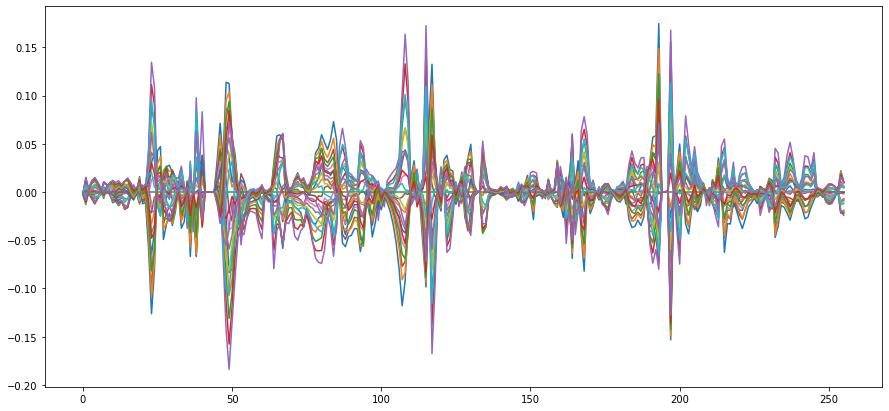

In [5]:
plt.figure(figsize=(15,7))
for num in range(25):
    plt.plot(dm_new[num, 1, :] - dm_new[12, 1, :])
plt.show()

Now lets look at some PDFs: We notice that they look very similar.

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


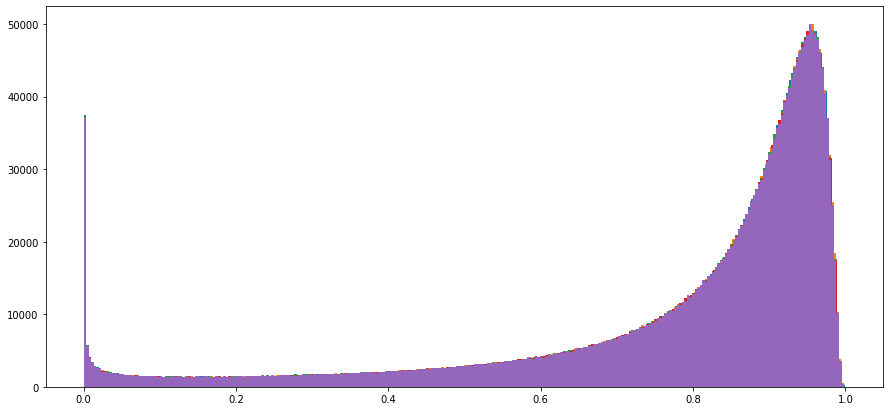

In [6]:
plt.figure(figsize=(15,7))
plt.hist(dm_new[2,:,:].flatten(),bins=300)
plt.hist(dm_new[7,:,:].flatten(),bins=300)
plt.hist(dm_new[12,:,:].flatten(),bins=300)
plt.hist(dm_new[17,:,:].flatten(),bins=300)
plt.hist(dm_new[22,:,:].flatten(), bins=300)
plt.show()

Time to learn the PDF!: Lets first set up the hyperparameters for Biwei's code. (I don't mess with this too much without asking Biwei if something is broken.)

In [7]:
#hyperparameters

#number of points for the interpolation
interp_nbin = 300
#kde kernel width factor
bw_factor = .05
#extrapolation method. regression or endpoint
extrapolate = 'regression'
#bin number of the edges
edge_bins = 10
#regularization parameter. [0,1]
alpha = 0
#clip the extrapolation derivatives
derivclip = None
#batch size for the transformation
batchsize = None

Loop through and transform each cosmology to a gaussian. We also plot the gaussians on one plot, showing that they are near identical.

0


/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


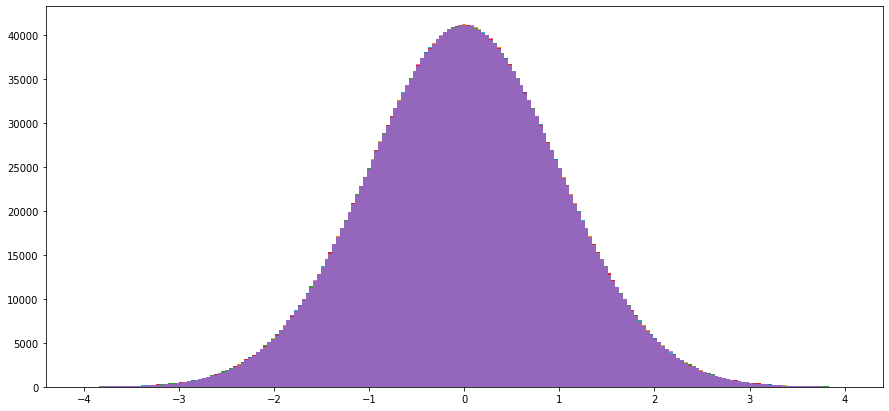

In [8]:
plt.figure(figsize=(15,7))

#this is the name of our untransformed dataset
dm_processed = np.zeros(shape=shape)
#transformations are stored here
transformations = []

rho0 = []
pdf0 = []

#transformed dataset
dm_transformed = np.zeros(shape=shape)
#jacobian
dm_logj = np.zeros(shape=shape)

for num in range(25):
    #keep track of the process in case the kernel breaks  :P
    print(num)
    
    dm_processed[num, :, :] = dataProcess(np.nan_to_num(dm_new[num, :, :]), 1, 1, noise_center = 0, noise_sd= 1e-1, count=10000)
    
    #converts them to pytorch arrays
    data = torch.Tensor(dm_processed[num, :, :].flatten())
    
    #data pdf
    rho_temp = kde(data, bw_factor=bw_factor)
    rho0.append(rho_temp)
    
    #we pass inputs into this function and save the outputs (should be between 0 and 1, but we do a wider set of values to be safe)
    x = torch.linspace(-.5, 1.5, 200)
    pdf0.append(rho_temp(x))

    #now learn the transformation
    T = SlicedTransport_pointwise(interp_nbin=interp_nbin).requires_grad_(False)
    T.fit(data, bw_factor=bw_factor, extrapolate=extrapolate, edge_bins=edge_bins, alpha=alpha, derivclip=derivclip, batchsize=batchsize)
    transformations.append(T)
    
    #transform the data and plot to show that it is gaussian
    #note we need to reshape the data since pytorch must take all the data flattened.
    data_t, logj_t = T(data)
    data_t = data_t.reshape(10000,256)
    dm_transformed[num,:,:] = data_t
    logj_t = logj_t.reshape(10000,256)
    dm_logj[num,:,:] = logj_t

    
    plt.hist(data_t.flatten(), bins=np.linspace(-4,4,200), normed=False)
    
plt.show()

Plotting power spectra of skewers (before and after transformation)

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


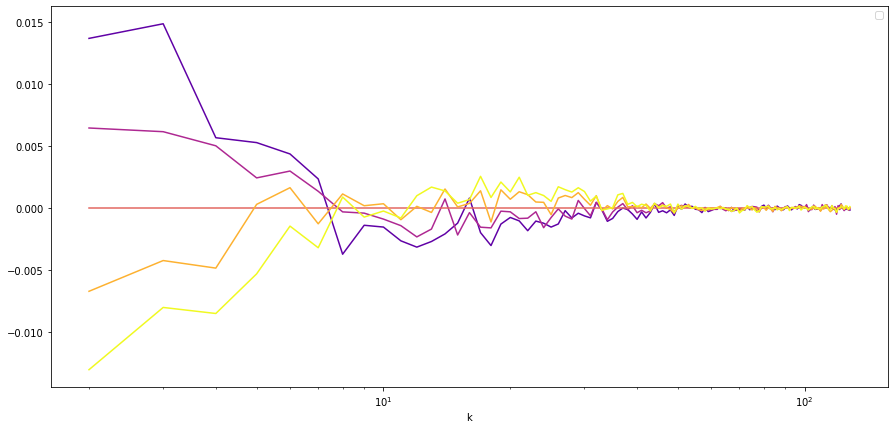

No handles with labels found to put in legend.


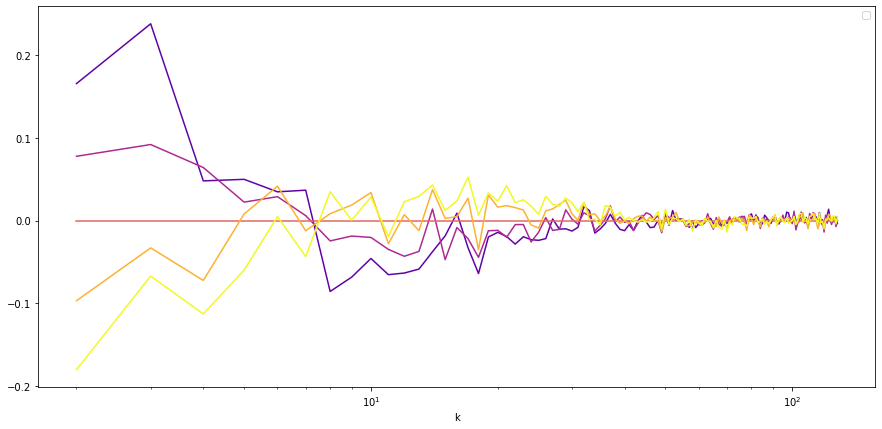

In [9]:
#change skewers plotted by changing bla
#i have no good way of picking cosmologies, i just remember the indexes. 
bla = [4,9,14,19,24] 

color = cm.get_cmap('plasma', max(bla))

#before transformation
plt.figure(figsize=(15,7))
x, pm2 = PowerSpectrum(dm_processed[bla[2], :, :], axis=1)

for num in bla:
    x, pm_1 = PowerSpectrum(dm_processed[num, :, :], axis=1)
    max_k = int(np.round(len(x)/2))
    #plt.errorbar(x[1:max_k], pm_1.mean(axis=0)[1:max_k]-pm2.mean(axis=0)[1:max_k], color=color(num-5))
    plt.errorbar(x[1:max_k], pm_1.mean(axis=0)[1:max_k]-pm2.mean(axis=0)[1:max_k], color=color(num))

plt.xscale('log')
plt.xlabel('k')
plt.legend()
plt.show()

#after transformation
plt.figure(figsize=(15,7))
x, pm2 = PowerSpectrum(dm_transformed[bla[2], :, :], axis=1)

for num in bla:
    x, pm_t1 = PowerSpectrum(dm_transformed[num, :, :], axis=1)
    max_k = int(np.round(len(x)/2))
    plt.errorbar(x[1:max_k], pm_t1.mean(axis=0)[1:max_k]-pm2.mean(axis=0)[1:max_k], color=color(num))
plt.xscale('log')
plt.xlabel('k')
plt.legend()
plt.show()

Defining our likelihood

In [10]:
#gaussian log-likelihood
def log_likelihood(transformed, sigma, logj):
    shape = transformed.shape
    
    r = transformed.flatten()
    hess = 1/sigma**2
    
    #positive log likelihood
    norm_logpdf =    - .5 * r * hess * r    + .5 * np.log(hess)     - .5 * np.log(2 * pi)
    grad_abs_log = logj

    loss_piece = -norm_logpdf-grad_abs_log
    
    loss = loss_piece.reshape(shape)
    
    return loss

Now we test whether we can infer cosmology. We now pick a dataset (in the first case, the mean datast, and tranforming it using all 25 of our transformations and then calculating a likelihood. The matching transformation should give the highest likelihood.

In [11]:
likelihood = np.zeros((25,25, 10000, 256))
data = np.zeros((25,25, 10000, 256))
logj = np.zeros((25,25, 10000, 256))

for num in range(25):
    for num2 in [12]:
        dataset = torch.Tensor(dm_processed[num2, :, :].flatten())
        print(num, num2)
        #print('dataset = ', dataset)
        d, l  = transformations[num](dataset)
        data[num, num2, :, :] = d.numpy().reshape(10000,256)
        logj[num, num2, :, :] = l.numpy().reshape(10000,256) 

        likelihood[num, num2, :, :] = log_likelihood(d, 1.0, l).reshape(10000,256)
        #print('likelihood = ', likelihood[num, num2, :, :].sum(axis=1).mean())

0 12
1 12
2 12
3 12
4 12
5 12
6 12
7 12
8 12
9 12
10 12
11 12
12 12
13 12
14 12
15 12
16 12
17 12
18 12
19 12
20 12
21 12
22 12
23 12
24 12


Plot the likelihood of our test skewer for each model in a 'heat map'. The brightest spot is the most likely cosmology. And it matches well with the truth, which is the red dot.

<Figure size 1080x504 with 0 Axes>

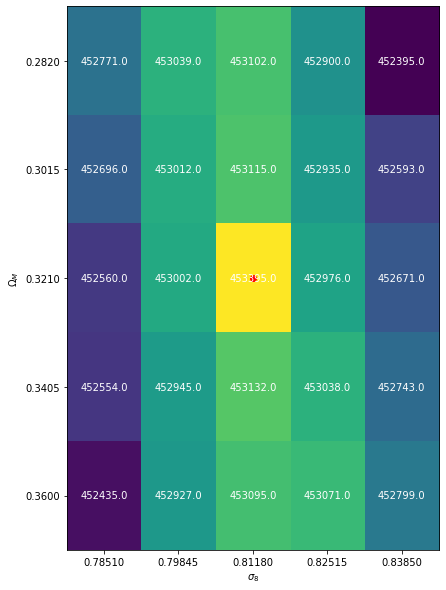

In [12]:
test_cosmo = 12

new_names = cosmo_names.reshape(5,5,2)

plt.figure(figsize=(15,7))
x = likelihood.sum(axis=2).sum(axis=2)

x_diff = (-new_names[0,0,1] + new_names[0,1,1])/2
y_diff = (-new_names[0,0,0] + new_names[1,0,0])/2

extent = (new_names[0,:,1].min() - x_diff, new_names[0,:,1].max() + x_diff, new_names[:,0,0].max() + y_diff, new_names[:,0,0].min() - y_diff)

plt.figure(figsize = (10,10))
for num in [test_cosmo]:
    temp = x[0:25, num]
    result = numpy.where(temp == np.amin(temp))
    temp =  temp.reshape(5,5)
    
    x = -temp
        
    plt.xticks(new_names[0,:,1])
    plt.yticks(new_names[:,0,0])

    plt.imshow(x, extent=extent)

    #plt.contour(x, extent=extent)
    plt.scatter(cosmo_names[test_cosmo,1], cosmo_names[test_cosmo,0], color='r')
    for i in range(len(new_names[0,:,1])):
        for j in range(len(new_names[:,0,0])):
            text = plt.text(new_names[0,i,1], new_names[j,0,0], np.round(x[j, i], decimals=0),
                           ha="center", va="center", color="w")
plt.xlabel('$\sigma_8$')
plt.ylabel("$\Omega_M$")
plt.show()

Doing the same thing with test data

In [13]:
test_dm = np.load("grid_skewers_test.npy")
print(test_dm.shape)
test_dm_processed = np.zeros(shape=(4,10000,256))

for num in range(3):
    test_dm_processed[num, :, :] = dataProcess(np.nan_to_num(test_dm[num, :, :]), 1, 1, noise_center = 0, noise_sd= 1e-1, count=10000)
    
test_dm = np.load("grid_skewers_test_2.npy")

for num in range(1):
    test_dm_processed[num+3, :, :] = dataProcess(np.nan_to_num(test_dm[num, :, :]), 1, 1, noise_center = 0, noise_sd= 1e-1, count=10000)

(4, 10000, 256)


In [14]:
likelihood_temp = np.zeros((25,4, 10000, 256))
data_temp = np.zeros((25,4, 10000, 256))
logj_temp = np.zeros((25,4, 10000, 256))

for num in range(25):
    print(num)
    for num2 in range(4):
        dataset = torch.Tensor(test_dm_processed[num2, :, :].flatten())
        #print('dataset = ', dataset)
        d, l  = transformations[num](dataset)
        data_temp[num, num2, :, :] = d.numpy().reshape(10000,256)
        logj_temp[num, num2, :, :] = l.numpy().reshape(10000,256) 
        likelihood_temp[num, num2, :, :] = log_likelihood(d, 1.0, l).numpy().reshape(10000,256)
       # print('likelihood = ', likelihood_temp[num, num2, :, :].sum(axis=1).mean())
        #first number is model #

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Defining power spectrum likelihood

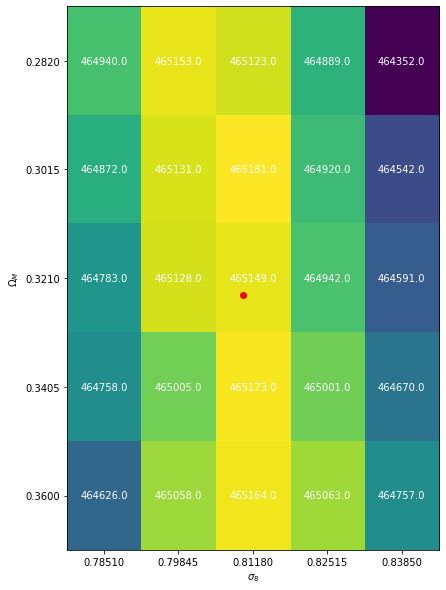

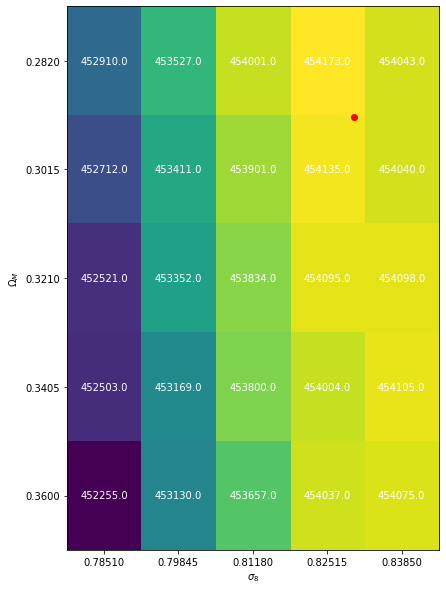

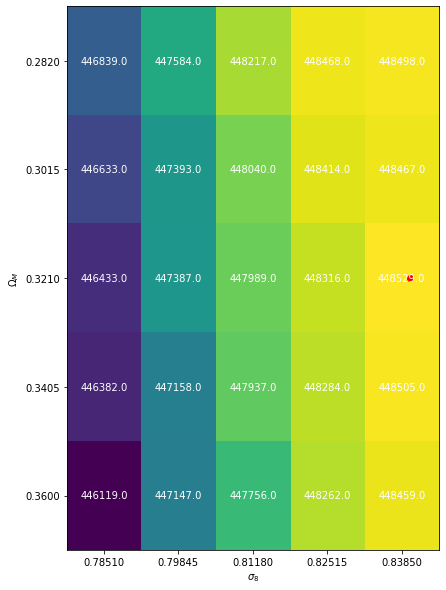

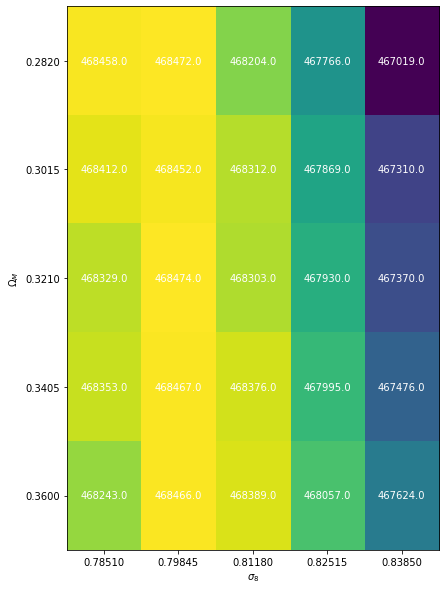

In [15]:
x = (likelihood_temp.sum(axis=2).sum(axis=2))

cosmos = np.array([[0.324,0.810],[0.292,0.83],[0.321,0.84]])
x_diff = (-new_names[0,0,1] + new_names[0,1,1])/2
y_diff = (-new_names[0,0,0] + new_names[1,0,0])/2

extent = (new_names[0,:,1].min() - x_diff, new_names[0,:,1].max() + x_diff, new_names[:,0,0].max() + y_diff, new_names[:,0,0].min() - y_diff)

for num in range(4):
    plt.figure(figsize = (10,10))

    temp = x[0:25, num]
    temp =  temp.reshape(5,5)
    
    y = -temp
    
    plt.xticks(new_names[0,:,1])
    plt.yticks(new_names[:,0,0])

    plt.imshow(y, extent=extent)

    #plt.contour(x, extent=extent)
    if num<3:
        plt.scatter(cosmos[num,1], cosmos[num,0], color='r')
    for i in range(len(new_names[0,:,1])):
        for j in range(len(new_names[:,0,0])):
            text = plt.text(new_names[0,i,1], new_names[j,0,0], np.round(y[j, i], decimals=0),
                           ha="center", va="center", color="w")
    plt.xlabel('$\sigma_8$')
    plt.ylabel("$\Omega_M$")
    plt.show()

Defining power spectrum likelihood

In [16]:
#gaussian log-likelihood with each ps mode as the variance
def log_likelihood_ps(data, ps):
    data = data.reshape(10000,256)
    x, F_fft = fft(data, axis=1)
    shape = F_fft.shape
    loss = np.zeros(shape)
    hess = 1/(ps.mean(axis=0))
    
    for num in range(2, 128):
        loss[:, num] = np.real(-.5 * F_fft[:, num] * hess[num]*np.ones(10000) * np.conjugate(F_fft[:, num])) + .5 * np.log(hess[num]) - .5 * np.log(2 * pi)

    
    return -loss

Now we check the likelihood using the power spectrum

In [18]:
likelihood_ps = np.zeros((25,25, 10000, 129))

for num in range(25):
    x, pm = PowerSpectrum(dm_processed[num, :, :], axis=1)
    for num2 in range(25):
        #first number is model
        #second number is applied dataset
        likelihood_ps[num, num2, :, :] = log_likelihood_ps(dm_transformed[num2, :, :], pm)


/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


Now we sum over the data. This gives us a likelihood for cosmology with respect to each model.

In [24]:
summed_likelihoods = likelihood_ps.sum(axis=2).sum(axis=2)

print(summed_likelihoods.shape)

#Lets check the highest likelihood (or lowest negative log likelihood) for each dataset. In principle, it should match
#we check over axis zero since thats the model axis
x = np.argmin(summed_likelihoods, axis=0)

print(x)

(25, 25)
[24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24]
